# ロジスティック回帰分析

## 分析の手順
1. 使用するデータセットを確認する
2. データセットを加工する
3. ロジスティック回帰式を求めることに意義があるか確認する
4. ロジスティック回帰式を求める
5. ロジスティック回帰式の精度
6. 回帰係数の検定

## 参考にする資料
- マンガでわかる統計学「回帰分析編」 高橋信 オーム社
- Pythonではじめる機械学習 オライリー・ジャパン
- https://qiita.com/TomokIshii/items/374ac7d4231adf6a39f4
- http://d.hatena.ne.jp/teramonagi/20171003/1507017733

---

## １．使用するデータセットの確認
取得元：http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#

### 分析の目的
**複数の説明変数から目的変数（翌月の支払い滞納）を予測する**

### 公開されていた情報
- 台湾のクレジットカード業者の請求・入金履歴データ
- 学習データの対象期間は、2005-04〜2010-09
- 予測対象は2005年10月の支払滞納（1=未納,0=入金）

```
default payment next month：翌月滞納 (Yes=1,No=0)  
  
   LIMIT_BAL  ：利用可能枠 (台湾新ドル、家族カードの利用可能枠を含む)  
   SEX        ：性別 (1=male,2=female)  
   EDUCATION  ：最終学歴 (1=graduate school,2=university,3=high school,4=others)  
   MARRIAGE   ：既婚/未婚/その他 (1=married,2=single,3=others) othersって!?  
   AGE        ：年齢 (year)  
   PAY_0-9    ：支払歴 (-1=遅延なく支払,1=1ヶ月延滞,...,8=8ヶ月延滞,9=9ヶ月以上延滞)  
   BILL_AMT1-6：請求額 (BILL_AMT1=請求額(2005年9月),BILL_AMT2=請求額(2005年8月),...BILL_AMT6=請求額(2005年4月))  
   PAY_AMT1-6 ：支払額 (PAY_AMT1=支払額(2005年9月),PAY_AMT2=支払額(2005年8月),...PAY_AMT6=支払額(2005年4月))
```

### 想定できるビジネス上の考慮点
- ボーナス払いや分割払い、リボルビング払いがありうる

### データセットを目検して気づいたこと
過去調べた実績をもとに割愛する
（https://github.com/selectfromwhere/scikit_learn_Memo/blob/master/Logistic_Regression.ipynb）
- PAY_0-9[支払歴]は、PAY_0,(飛んで),PAY_2,PAY_3,PAY_4,PAY_5,PAY_6しか存在しない
- 請求額と支払額が一致しないレコードが存在する
- 支払い歴に説明のない(-2,0)が存在する  
https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/discussion/34608  
```
-2: No consumption(請求なし);  
 0: The use of revolving credit(リボルビング払い);  
```
- 'PAY_7','PAY_8','PAY_9'は存在していない

---

In [27]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

## ２．データセットの加工

カラム名をわかりやすい名称に変換する

In [28]:
df = pd.read_excel('Default_of_Credit_Card_Clients.xls', header=1, sheetname='Data').drop("ID",axis=1)
df.rename(columns={'PAY_0':'PAY_Sep',
                   'PAY_2':'PAY_Aug',
                   'PAY_3':'PAY_Jul',
                   'PAY_4':'PAY_Jun',
                   'PAY_5':'PAY_May',
                   'PAY_6':'PAY_Apr',
                   'BILL_AMT1':'BILL_AMT_Sep',
                   'BILL_AMT2':'BILL_AMT_Aug',
                   'BILL_AMT3':'BILL_AMT_Jul',
                   'BILL_AMT4':'BILL_AMT_Jun',
                   'BILL_AMT5':'BILL_AMT_May',
                   'BILL_AMT6':'BILL_AMT_Apr',
                   'PAY_AMT1':'PAY_AMT_Sep',
                   'PAY_AMT2':'PAY_AMT_Aug',
                   'PAY_AMT3':'PAY_AMT_Jul',
                   'PAY_AMT4':'PAY_AMT_Jun',
                   'PAY_AMT5':'PAY_AMT_May',
                   'PAY_AMT6':'PAY_AMT_Apr',
                   'default payment next month':'DEF_PAY'}, inplace=True)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_Sep,PAY_Aug,PAY_Jul,PAY_Jun,PAY_May,...,BILL_AMT_Jun,BILL_AMT_May,BILL_AMT_Apr,PAY_AMT_Sep,PAY_AMT_Aug,PAY_AMT_Jul,PAY_AMT_Jun,PAY_AMT_May,PAY_AMT_Apr,DEF_PAY
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [29]:
df.dtypes

LIMIT_BAL       int64
SEX             int64
EDUCATION       int64
MARRIAGE        int64
AGE             int64
PAY_Sep         int64
PAY_Aug         int64
PAY_Jul         int64
PAY_Jun         int64
PAY_May         int64
PAY_Apr         int64
BILL_AMT_Sep    int64
BILL_AMT_Aug    int64
BILL_AMT_Jul    int64
BILL_AMT_Jun    int64
BILL_AMT_May    int64
BILL_AMT_Apr    int64
PAY_AMT_Sep     int64
PAY_AMT_Aug     int64
PAY_AMT_Jul     int64
PAY_AMT_Jun     int64
PAY_AMT_May     int64
PAY_AMT_Apr     int64
DEF_PAY         int64
dtype: object

In [30]:
df.describe(include='all')

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_Sep,PAY_Aug,PAY_Jul,PAY_Jun,PAY_May,...,BILL_AMT_Jun,BILL_AMT_May,BILL_AMT_Apr,PAY_AMT_Sep,PAY_AMT_Aug,PAY_AMT_Jul,PAY_AMT_Jun,PAY_AMT_May,PAY_AMT_Apr,DEF_PAY
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


### 気づいたこと
- 30,000件の履歴データ
- 欠損値はない
- 請求額と支払額は多重共線性の問題が発生するため除外する

---

## ３．回帰式を求めることに意義があるか確認する

In [31]:
df_plot = df[['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE','PAY_Apr','PAY_May','PAY_Jun','PAY_Jul','PAY_Aug','PAY_Sep','DEF_PAY']]

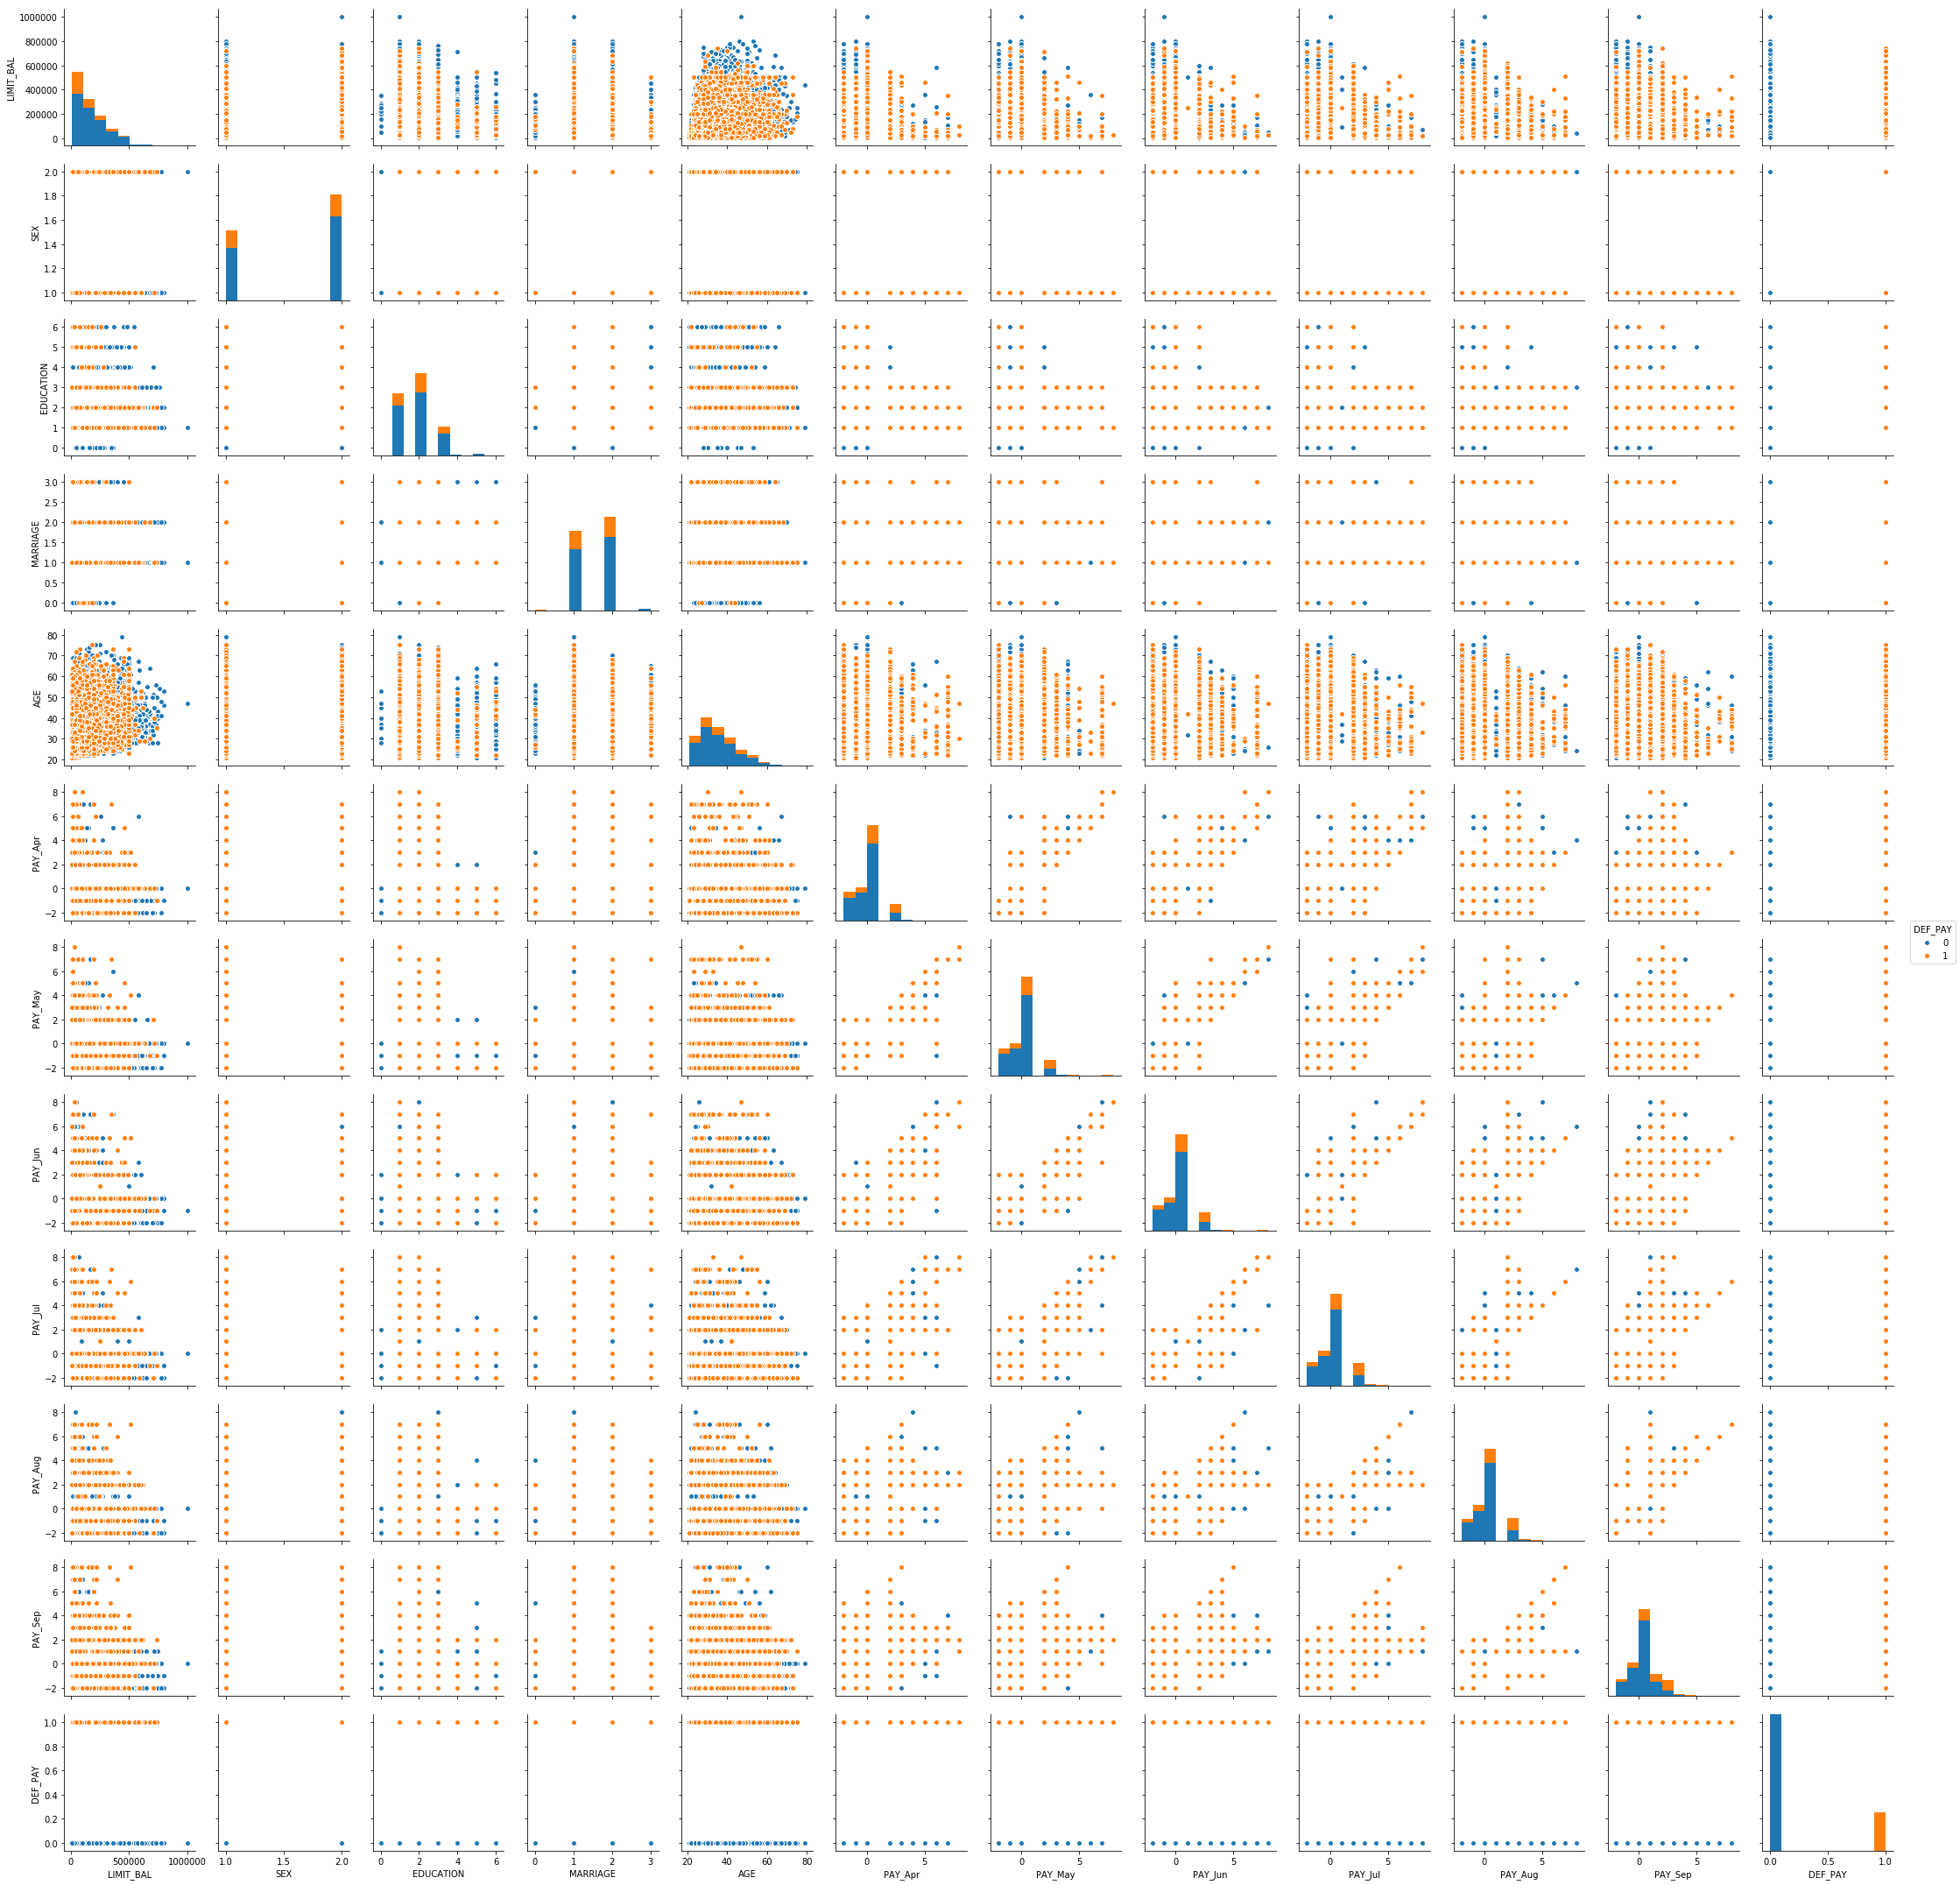

In [32]:
sns.pairplot(df_plot, hue="DEF_PAY")

In [33]:
# 翌月滞納と各変数の単相関係数を確認する
col_name = df_plot.columns.values
for i in range(len(col_name)-1):
    x = df_plot[col_name[i]]
    y = df_plot['DEF_PAY']
    rxy = np.corrcoef(x,y)
    print("単相関係数:{}".format(rxy[0][1]), " :{}".format(col_name[i]))

単相関係数:-0.15351987639350764  :LIMIT_BAL
単相関係数:-0.03996057770544171  :SEX
単相関係数:0.02800607765624998  :EDUCATION
単相関係数:-0.024339215683404185  :MARRIAGE
単相関係数:0.013889834301963224  :AGE
単相関係数:0.18686636165354517  :PAY_Apr
単相関係数:0.2041489138761666  :PAY_May
単相関係数:0.21661363684242446  :PAY_Jun
単相関係数:0.235252513724916  :PAY_Jul
単相関係数:0.26355120167216467  :PAY_Aug
単相関係数:0.32479372847862265  :PAY_Sep


- 個々の説明変数と目的変数の相関関係は強くないが、支払歴は新しいほど翌月の滞納との関連が強くなる
- 利用可能枠は意外と関連が強くない

---

## ４．回帰式を求める

statsmodelsとscikit-learnの両方でモデルを作成する

In [34]:
X = df[['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE','PAY_Apr','PAY_May','PAY_Jun','PAY_Jul','PAY_Aug','PAY_Sep']]
Y = df['DEF_PAY']

In [35]:
model = sm.Logit(Y, sm.add_constant(X))
result = model.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.468591
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                DEF_PAY   No. Observations:                30000
Model:                          Logit   Df Residuals:                    29988
Method:                           MLE   Df Model:                           11
Date:                Tue, 15 May 2018   Pseudo R-squ.:                  0.1132
Time:                        23:36:23   Log-Likelihood:                -14058.
converged:                       True   LL-Null:                       -15853.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.7358      0.118     -6.248      0.000        -0.967    -0.505
LIMIT_BAL   -1.81e-06   1.38e-07    -13.165      0.000     -2.08e-06 -1.54e-06
SEX           -0.0929      0.031     -3.043      0.002        -0.153    -0.033
EDUCATION     -0.1204      0.021     -5.801      0.000        -0.161    -0.080
MARRIAGE      -0.1671      0.032     -5.305      0.000        -0.229    -0.105
AGE            0.0076      0.002      4.289      0.000         0.004     0.011
PAY_Apr       -0.0043      0.022     -0.196      0.845        -0.047     0.038
PAY_May        0.0328      0.027      1.237      0.216        -0.019     0.085
PAY_Jun        0.0136      0.025      0.551      0.582        -0.035     0.062
PAY_Jul        0.0740      0.022      3.334      0.001         0.030     0.117
PAY_Aug        0.0683      0.020      3.431      0.001         0.029     0.107
PAY_Sep        0.5979      0.018     33.551      0.000         0.563     0.633
==============================================================================
"""

In [36]:
result.params

const       -0.735805
LIMIT_BAL   -0.000002
SEX         -0.092851
EDUCATION   -0.120360
MARRIAGE    -0.167123
AGE          0.007581
PAY_Apr     -0.004256
PAY_May      0.032849
PAY_Jun      0.013591
PAY_Jul      0.073993
PAY_Aug      0.068319
PAY_Sep      0.597916
dtype: float64

In [37]:
result.resid_pearson

0        0.997958
1        2.699842
2       -0.496178
3       -0.565705
4       -0.456850
5       -0.578893
6       -0.373714
7       -0.440170
8       -0.510969
9       -0.242794
10      -0.456374
11      -0.323790
12      -0.218691
13       1.239169
14      -0.468609
15      -0.617068
16       1.572371
17      -0.505067
18      -0.532517
19      -0.534411
20      -0.460186
21       2.763963
22       1.075668
23       5.168538
24      -0.525868
25      -0.486720
26       1.523551
27      -0.477134
28      -0.374126
29      -0.555252
           ...   
29970   -0.325296
29971   -0.540976
29972   -0.555623
29973    1.784783
29974    1.070790
29975   -0.479817
29976    0.771402
29977   -0.409465
29978   -0.471891
29979   -0.251049
29980   -0.523067
29981   -0.959001
29982    1.756375
29983   -0.285938
29984   -0.363082
29985   -0.217066
29986   -0.276900
29987   -0.532369
29988   -0.519197
29989   -0.355650
29990   -0.554574
29991    0.669033
29992   -0.567410
29993   -0.517234
29994    0

---

In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:
Y = Y.values

In [40]:
# LogisticRegressionでモデルを作成
model_sk = LogisticRegression()
model_sk.fit(X,Y)

model_sk.score(X,Y)

0.77880000000000005

In [41]:
from pandas import DataFrame
DataFrame([X.columns, model_sk.coef_[0]]).T

,0,1
0,LIMIT_BAL,-5.26002e-06
1,SEX,-0.000514679
2,EDUCATION,-0.000644289
3,MARRIAGE,-0.000552566
4,AGE,-0.00907855
5,PAY_Apr,0.000406061
6,PAY_May,0.000428339
7,PAY_Jun,0.000445863
8,PAY_Jul,0.000478645
9,PAY_Aug,0.000547339
